In [152]:
import os
from os.path import join
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import layer_utils, to_categorical, plot_model
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.preprocessing import image
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG
import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

print(os.listdir("./input"))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


In [153]:
df=pd.read_pickle("./input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [154]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [155]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


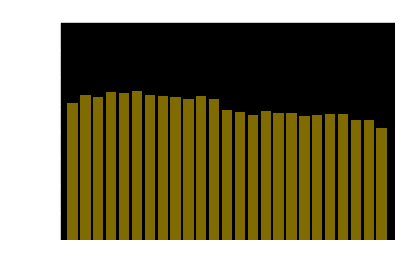

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [157]:
df = df.drop(['waferIndex'], axis = 1)

In [158]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
78781,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",1187.0,lot5750,[],[],"(51, 30)"
163080,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot10485,[],[],"(212, 84)"
255734,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3599.0,lot15848,[],[],"(79, 58)"
459106,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",712.0,lot28276,[],[],"(32, 29)"
455844,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",796.0,lot28085,[],[],"(31, 33)"


In [159]:
Wdim = np.unique(df['waferMapDim'])

In [160]:
cnt = np.zeros(Wdim.size)
c_maxdim = 0

for i in range(Wdim.size):
    sdf = df.loc[df['waferMapDim'] == Wdim[i]]
    cnt[i] = 0

    for j in range(len(sdf)):
    # skip null label
        if len(sdf.iloc[j,:]['failureType']) == 0:
            continue
        cnt[i] += 1

    if cnt[i] > c_maxdim:
        c_maxdim = cnt[i]
        c_index = i

print(c_maxdim)
print(Wdim[c_index])

18781.0
(25, 27)


In [161]:
sub_df = df.loc[df['waferMapDim'] == (25, 27)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 25, 27))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 25, 27)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [162]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [163]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (18781, 25, 27), y shape : (18781, 1)


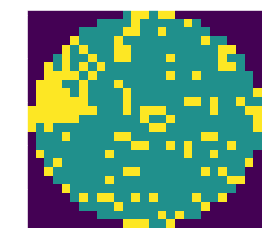

Faulty case : ['Edge-Loc'] 


In [164]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [165]:
#add channel
x = x.reshape((-1, 25, 27, 1))

In [166]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random' 'Scratch'
 'none']


In [167]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2251
Edge-Loc : 355
Edge-Ring : 25
Loc : 172
Near-full : 21
Random : 53
Scratch : 23
none : 15881


In [168]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 25, 27, 3))

for w in range(len(x)):
    for i in range(25):
        for j in range(27):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [169]:
#check new x dimension
new_x.shape

(18781, 25, 27, 3)

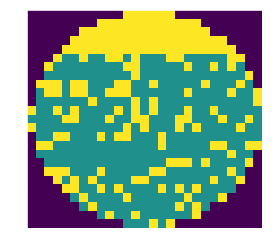

In [170]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

In [171]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [172]:
# delete choiced index data.
new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [173]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (7781, 25, 27, 1), new_y shape : (7781, 1)


In [174]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2251
Edge-Loc : 355
Edge-Ring : 25
Loc : 172
Near-full : 21
Random : 53
Scratch : 23
none : 4881


In [175]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [176]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [177]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (5213, 25, 27, 1), y : (5213, 8)
Test x: (2568, 25, 27, 1), y : (2568, 8)


In [178]:
# parameter
epoch=30
batch_size=900

In [179]:
def create_model():
    input_shape = (25, 27, 1)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(8, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
 
    return model

In [180]:
W_model = create_model()

In [181]:
W_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [182]:
Hist = W_model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size)

Epoch 1/30
5213/5213 [==============================] - 10s 2ms/step - loss: 1.7579 - accuracy: 0.5032
Epoch 2/30
5213/5213 [==============================] - 5s 931us/step - loss: 0.7569 - accuracy: 0.7614
Epoch 3/30
5213/5213 [==============================] - 5s 980us/step - loss: 0.4892 - accuracy: 0.9102
Epoch 4/30
5213/5213 [==============================] - 5s 1ms/step - loss: 0.4388 - accuracy: 0.9102
Epoch 5/30
5213/5213 [==============================] - 5s 1ms/step - loss: 0.4219 - accuracy: 0.9102
Epoch 6/30
5213/5213 [==============================] - 5s 1ms/step - loss: 0.4035 - accuracy: 0.9102
Epoch 7/30
5213/5213 [==============================] - 6s 1ms/step - loss: 0.3744 - accuracy: 0.9102
Epoch 8/30
5213/5213 [==============================] - 6s 1ms/step - loss: 0.3363 - accuracy: 0.9102
Epoch 9/30
5213/5213 [==============================] - 6s 1ms/step - loss: 0.3032 - accuracy: 0.9162
Epoch 10/30
5213/5213 [==============================] - 6s 1ms/step - loss: 

In [183]:
### START CODE HERE ### (1 line)
preds = W_model.evaluate(x = x_test, y = y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2568/2568 [==============================] - 1s 495us/step

Loss = 0.5410839209972802
Test Accuracy = 0.9236760139465332
